In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import numpy as np
import retrieval_311
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.regularizers import l2

In [2]:
df = pd.read_csv("data/processed_data.csv")

In [3]:
df.head()

,Unnamed: 0,datetime,calls,month,dayofweek,dayofmonth,hourofday
0,0,2008-07-01 00:00:00,2,7,1,1,0
1,1,2008-07-01 01:00:00,0,7,1,1,1
2,2,2008-07-01 02:00:00,0,7,1,1,2
3,3,2008-07-01 03:00:00,1,7,1,1,3
4,4,2008-07-01 04:00:00,0,7,1,1,4


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y-%m-%d")
df = df[(df['datetime'].dt.year > 2008) & (df['datetime'].dt.year < 2023)]
df = df.set_index('datetime')
df = df.drop("Unnamed: 0", axis=1)
df['year'] = df.index.year
df['date'] = df.index.date

In [5]:
print("----- Descriptive Statistics -----")
print(df['calls'].describe())
print("Sum:", df['calls'].sum())

----- Descriptive Statistics -----
count    122712.000000
mean         17.626622
std          22.591759
min           0.000000
25%           2.000000
50%           8.000000
75%          25.000000
max         553.000000
Name: calls, dtype: float64
Sum: 2162998


In [6]:
print("Fold Sizes")
print(pd.DataFrame(df.index.year.value_counts().sort_index()).rename(columns={'datetime': 'Fold Size'}).T)

Fold Sizes
           2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  \
Fold Size  8760  8760  8760  8784  8760  8760  8760  8784  8760  8760  8760   

           2020  2021  2022  
Fold Size  8784  8760  8760  


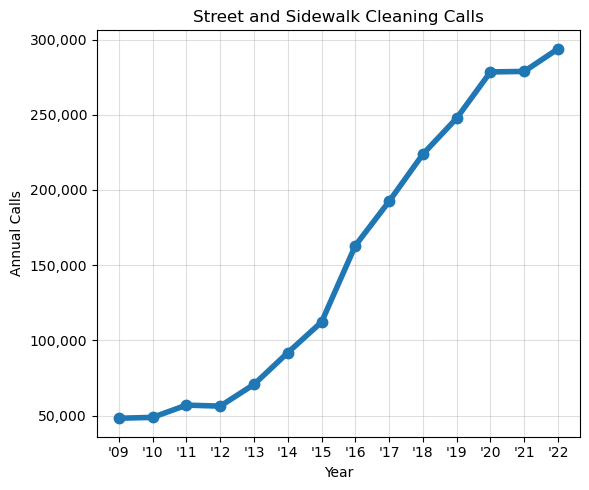

In [7]:
year_group = df.groupby("year")['calls'].sum()
# year_group = year_group.iloc[:-1]
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(year_group, ".-", linewidth=4, markersize=15)
ax.set_xticks(year_group.index)
ax.set_xticklabels(["'"+str(y)[-2:] for y in year_group.index])
ax.grid(alpha=.4)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set(title="Street and Sidewalk Cleaning Calls", xlabel="Year", ylabel="Annual Calls")
fig.tight_layout()
fig.savefig("figures/annual_trend.png", dpi=300)

In [8]:
def evaluate_fit(actual_calls, test_preds):
    rmse = np.mean((actual_calls - test_preds)**2)**.5
    r2 = r2_score(actual_calls, test_preds)
    max_resid = np.max(np.abs(actual_calls - test_preds))
    print("rmse", rmse)
    print("r2", r2)
    print("max resid", max_resid)
    return rmse, r2, max_resid


In [10]:
all_years = df.index.year.unique()
print("----- Naive Baseline Model -----")
rmses = []
r2s = []
max_resids = []
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = df[df.index.year == all_years[i]]
    test_data = df[df.index.year == all_years[i+1]]
    lag = 24*2
    test_preds = train_data['calls'].shift(lag).dropna()
    test_preds.index = test_preds.index + pd.DateOffset(years=1)
    actual_calls = test_data['calls'].iloc[lag:]
    merged = pd.merge(test_preds, actual_calls, left_index=True, right_index=True)
    actual_calls = merged['calls_y']
    test_preds = merged['calls_x']
    rmse, r2, max_resid = evaluate_fit(actual_calls, test_preds)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)
print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))
print()

----- Naive Baseline Model -----
2009 --> 2010
rmse 5.609386810131294
r2 0.2004180223499794
max resid 38.0
2010 --> 2011
rmse 6.305552015953506
r2 0.24044542701890992
max resid 41.0
2011 --> 2012
rmse 6.551265307937561
r2 0.18907831378440365
max resid 117.0
2012 --> 2013
rmse 7.450316203924605
r2 0.24800447678655924
max resid 133.0
2013 --> 2014
rmse 8.926647306776358
r2 0.3461654111005241
max resid 152.0
2014 --> 2015
rmse 10.190725946506678
r2 0.3378691038852478
max resid 142.0
2015 --> 2016
rmse 14.566150837800919
r2 0.35390855235440943
max resid 105.0
2016 --> 2017
rmse 15.55052029093179
r2 0.4531249436179995
max resid 91.0
2017 --> 2018
rmse 17.036472380882522
r2 0.5011373804374825
max resid 239.0
2018 --> 2019
rmse 18.018043960780965
r2 0.5542244910779695
max resid 263.0
2019 --> 2020
rmse 19.441971179448757
r2 0.5620363490435625
max resid 289.0
2020 --> 2021
rmse 21.3977838964145
r2 0.5667698208998744
max resid 442.0

Mean RMSE: 12.587069678124122
Mean r2: 0.37943185769641014
Ma

In [11]:
n_steps = 48
X_ = df.copy()[['calls']]
for i in range(1, n_steps+1):
    X_[f'lag_{i}'] = X_['calls'].shift(i)

In [12]:
X_ = X_.dropna()

In [13]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    lm = LinearRegression()
    lm.fit(X_train_scaled, y_train_scaled)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))

----- Regression With Lags -----
2009 --> 2010
rmse 3.7693269749331217
r2 0.42702776226472905
max resid 29.18288986337003
2010 --> 2011
rmse 4.367847771353403
r2 0.39352916745044175
max resid 37.70959016164434
2011 --> 2012
rmse 4.513121121967147
r2 0.38289401659104416
max resid 126.26354242643939
2012 --> 2013
rmse 4.804020277195866
r2 0.5093591595603264
max resid 35.26866028585498
2013 --> 2014
rmse 6.248891650160857
r2 0.49631429981022046
max resid 151.3967777481542
2014 --> 2015
rmse 6.538795258238863
r2 0.6165287351622348
max resid 70.79267581607405
2015 --> 2016
rmse 9.200039380382208
r2 0.5971082083755457
max resid 96.3364571486492
2016 --> 2017
rmse 9.159397358157154
r2 0.7544116305634567
max resid 85.5076332372751
2017 --> 2018
rmse 10.880094678124307
r2 0.7406458973800923
max resid 219.96825970832916
2018 --> 2019
rmse 11.731135875710885
r2 0.7645793439620926
max resid 262.655132359646
2019 --> 2020
rmse 12.62038694526827
r2 0.7723444852865617
max resid 256.7704331827631
2020

In [14]:
split = int(X_.shape[0] * .8)
train_data = X_.iloc[:split, :]
test_data = X_.iloc[split:, :]

X_train = train_data.drop('calls', axis=1).values
y_train = train_data[['calls']].values
X_test = test_data.drop('calls', axis=1).values
y_test = test_data[['calls']].values

scaler_X = StandardScaler()
scaler_X.fit(X_train)
scaler_y = StandardScaler()
scaler_y.fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
y_train_scaled = scaler_y.transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled = np.clip(X_train_scaled, -3, 3)
X_test_scaled = np.clip(X_test_scaled, -3, 3)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train_scaled)
test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled))
train_preds = scaler_y.inverse_transform(lm.predict(X_train_scaled))
actual_calls = y_test

In [15]:
X_temp = X_.copy()
X_temp['pred' ] = np.vstack([train_preds, test_preds])

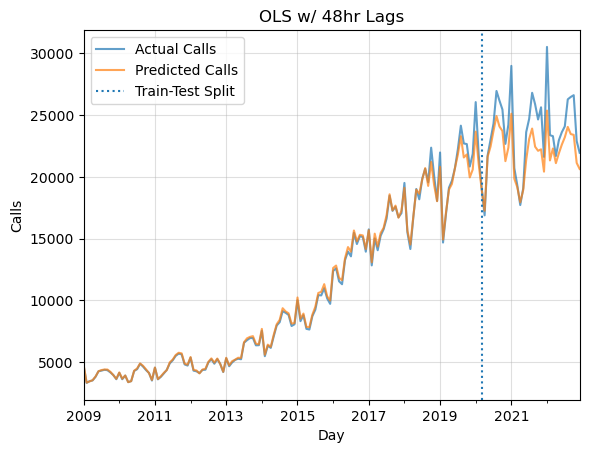

In [16]:
fig, ax = plt.subplots()
agg_table = X_temp.resample("1M")[['calls', 'pred']].sum()
agg_table.columns = ["Actual Calls", "Predicted Calls"]
agg_table.plot(alpha=.7, ax=ax)
ax.set(xlabel="Day", ylabel="Calls", title="OLS w/ 48hr Lags")
ax.axvline(X_.index[split], label="Train-Test Split", linestyle=":")
ax.grid(alpha=.4)
ax.legend()
fig.savefig("figures/OLS.png", dpi=300)


In [147]:
# all_years = df.index.year.unique()
# rmses = []
# r2s = []
# max_resids = []

# print("----- Ridge Regression With Lags -----")
# for i in range(len(all_years)-2):
#     print(all_years[i], "-->", all_years[i+1])
#     train_data = X_[(X_.index.year == all_years[i])]
#     test_data = X_[X_.index.year == all_years[i+1]]

#     X_train = train_data.drop('calls', axis=1).values
#     y_train = train_data[['calls']].values

#     X_test = test_data.drop('calls', axis=1).values
#     y_test = test_data[['calls']].values

#     scaler_X = StandardScaler()
#     scaler_X.fit(X_train)
#     scaler_y = StandardScaler()
#     scaler_y.fit(y_train)

#     X_train_scaled = scaler_X.transform(X_train)
#     y_train_scaled = scaler_y.transform(y_train)
#     X_test_scaled = scaler_X.transform(X_test)
#     y_test_scaled = scaler_y.transform(y_test)

#     X_train_scaled = np.clip(X_train_scaled, -3, 3)
#     X_test_scaled = np.clip(X_test_scaled, -3, 3)

#     y_train_scaled = y_train_scaled.flatten()
#     y_test_scaled = y_test_scaled.flatten()

#     lm = LinearRegression()
#     lm.fit(X_train_scaled, y_train_scaled)
#     test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled).reshape(-1, 1))
#     actual_calls = y_test
#     rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
#     rmses.append(rmse)
#     r2s.append(r2)
#     max_resids.append(max_resid)

# print()
# print("Mean RMSE:", np.mean(rmses))
# print("Mean r2:", np.mean(r2s))
# print("Max resid:", np.mean(max_resids))


In [130]:
# all_years = df.index.year.unique()
# rmses = []
# r2s = []
# max_resids = []

# print("----- Lasso Regression, 2 train 1 test, With Lags -----")
# for i in range(len(all_years)-3):
#     print(all_years[i], "-->", all_years[i+1], "-->", all_years[i+2])
#     train_data = X_[(X_.index.year == all_years[i]) | X_.index.year == all_years[i+1]]
#     test_data = X_[X_.index.year == all_years[i+2]]

#     X_train = train_data.drop('calls', axis=1).values
#     y_train = train_data[['calls']].values

#     X_test = test_data.drop('calls', axis=1).values
#     y_test = test_data[['calls']].values

#     scaler_X = StandardScaler()
#     scaler_X.fit(X_train)
#     scaler_y = StandardScaler()
#     scaler_y.fit(y_train)

#     X_train_scaled = scaler_X.transform(X_train)
#     y_train_scaled = scaler_y.transform(y_train)
#     X_test_scaled = scaler_X.transform(X_test)
#     y_test_scaled = scaler_y.transform(y_test)

#     # X_train_scaled = np.clip(X_train_scaled, -3, 3)
#     X_test_scaled = np.clip(X_test_scaled, -3, 3)

#     y_train_scaled = y_train_scaled.flatten()
#     y_test_scaled = y_test_scaled.flatten()

#     lm = LassoCV(alphas=np.linspace(0.0001, 1, 10), cv=TimeSeriesSplit(n_splits=5))
#     lm.fit(X_train_scaled, y_train_scaled)
#     print("alpha =", lm.alpha_)
#     test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled).reshape(-1, 1))
#     actual_calls = y_test
#     rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
#     rmses.append(rmse)
#     r2s.append(r2)
#     max_resids.append(max_resid)

# print()
# print("Mean RMSE:", np.mean(rmses))
# print("Mean r2:", np.mean(r2s))
# print("Max resid:", np.mean(max_resids))


In [17]:
all_years = df.index.year.unique()

rmses = []
r2s = []
max_resids = []

print("----- Ridge Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[(X_.index.year == all_years[i])]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    y_train_scaled = y_train_scaled.flatten()
    y_test_scaled = y_test_scaled.flatten()

    lm = RidgeCV(alphas=np.linspace(0.001, 10, 10), cv=TimeSeriesSplit(n_splits=4))
    lm.fit(X_train_scaled, y_train_scaled)
    print("alpha =", lm.alpha_)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled).reshape(-1, 1))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


----- Ridge Regression With Lags -----
2009 --> 2010
alpha = 10.0
rmse 3.7693732312261274
r2 0.4265793952029253
max resid 29.18466375204435
2010 --> 2011
alpha = 10.0
rmse 4.36780685438758
r2 0.3930761289749386
max resid 37.69550431804293
2011 --> 2012
alpha = 10.0
rmse 4.513025660861542
r2 0.38243172137365644
max resid 126.25926860980434
2012 --> 2013
alpha = 10.0
rmse 4.804317960378147
r2 0.5089448257070524
max resid 35.26951107230978
2013 --> 2014
alpha = 10.0
rmse 6.249164579988027
r2 0.49593331817124164
max resid 151.41616712097328
2014 --> 2015
alpha = 10.0
rmse 6.538987520675371
r2 0.6162565305473601
max resid 70.81105191490121
2015 --> 2016
alpha = 10.0
rmse 9.202322146614017
r2 0.5966564637115488
max resid 96.34573622546104
2016 --> 2017
alpha = 10.0
rmse 9.161093917938777
r2 0.7541193795738158
max resid 85.45926680957616
2017 --> 2018
alpha = 10.0
rmse 10.880710383933527
r2 0.7403684610757633
max resid 220.05115044303565
2018 --> 2019
alpha = 0.001
rmse 11.731135810767675
r2 

In [18]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Lasso Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    y_train_scaled = y_train_scaled.flatten()
    y_test_scaled = y_test_scaled.flatten()

    lm = LassoCV(alphas=np.linspace(0.001, 10, 10), cv=TimeSeriesSplit(n_splits=4))
    lm.fit(X_train_scaled, y_train_scaled)
    print("alpha =", lm.alpha_)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled).reshape(-1, 1))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


----- Lasso Regression With Lags -----
2009 --> 2010
alpha = 0.001
rmse 3.7680767107065307
r2 0.4243270776361786
max resid 29.10382183808273
2010 --> 2011
alpha = 0.001
rmse 4.367671494253416
r2 0.39072778374586814
max resid 37.67268034387083
2011 --> 2012
alpha = 0.001
rmse 4.511741597608218
r2 0.37994276521249637
max resid 126.18612156404119
2012 --> 2013
alpha = 0.001
rmse 4.802161026322575
r2 0.507262728974063
max resid 35.444731960069205
2013 --> 2014
alpha = 0.001
rmse 6.249034636037996
r2 0.4942455779313808
max resid 151.51390635703746
2014 --> 2015
alpha = 0.001
rmse 6.536287360738606
r2 0.6150882047514539
max resid 70.57011422955918
2015 --> 2016
alpha = 0.001
rmse 9.206002557176818
r2 0.5948303523582388
max resid 96.01844606424285
2016 --> 2017
alpha = 0.001
rmse 9.151259007428834
r2 0.7537072670085122
max resid 85.97664744653187
2017 --> 2018
alpha = 0.001
rmse 10.876610227995121
r2 0.7397866808409391
max resid 219.88484900596347
2018 --> 2019
alpha = 0.001
rmse 11.728429831

In [ ]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Lasso Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    y_train_scaled = y_train_scaled.flatten()
    y_test_scaled = y_test_scaled.flatten()

    lm = LassoCV(alphas=np.linspace(0.001, 10, 10), cv=TimeSeriesSplit(n_splits=4))
    lm.fit(X_train_scaled, y_train_scaled)
    print("alpha =", lm.alpha_)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled).reshape(-1, 1))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


In [20]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Random Forrest Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    y_train_scaled = y_train_scaled.flatten()
    y_test_scaled = y_test_scaled.flatten()

    param_grid = {
    'n_estimators': [50, 100, 150]
    }
    
    rf = RandomForestRegressor(verbose=0, n_jobs=-1, bootstrap=True)
    lm = GridSearchCV(rf, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=4))
    lm.fit(X_train_scaled, y_train_scaled)
    print(lm.best_params_)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled).reshape(-1, 1))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


----- Random Forrest Regression With Lags -----
2009 --> 2010


KeyboardInterrupt: 

In [ ]:
importances = lm.feature_importances_
std = np.std([tree.feature_importances_ for tree in lm.estimators_], axis=0)
indices = np.argsort(importances)[::-1] + 1

In [ ]:
indices + 1

array([25,  2, 49, 29, 24, 36,  4, 21, 19,  3, 17, 22, 28, 35, 48, 27, 26,
       23, 18, 42, 11,  9, 20, 44, 46, 47, 43, 34, 37, 39, 41,  5, 16, 30,
       40, 12,  6, 38, 13, 45, 14, 15,  7, 31,  8, 32, 33, 10],
      dtype=int64)

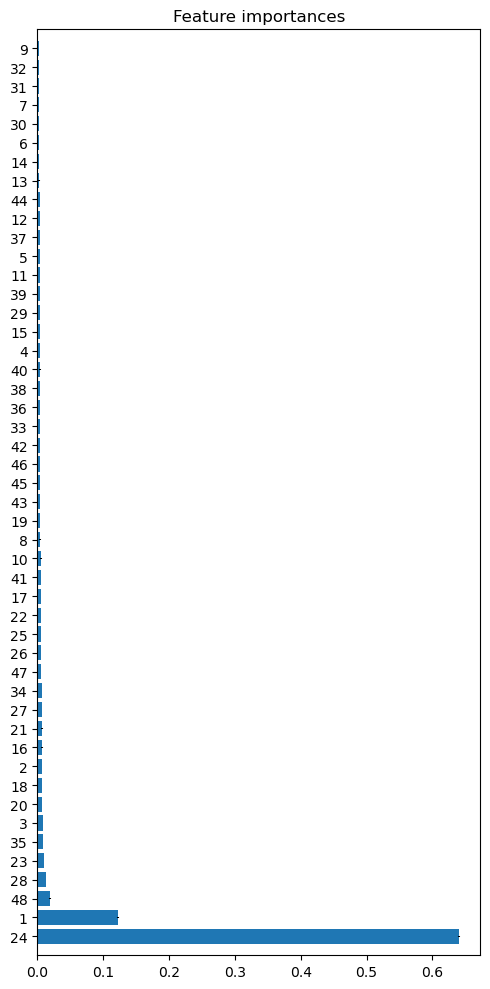

In [ ]:
fig, ax = plt.subplots(figsize=(5, 8))
ax.set_title("Feature importances")
ax.barh(range(X_train_scaled.shape[1]), importances[indices-1], yerr=std[indices-1], align="center")
ax.set_yticks(range(X_train_scaled.shape[1]), indices)
ax.set_ylim([-1, X_train_scaled.shape[1]])
fig.tight_layout()
fig.savefig("figures/RF_plot.png", dpi=300)


In [ ]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Vanilla RNN With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    model = Sequential()
    model.add(SimpleRNN(200, activation='relu', return_sequences=True, input_shape=(n_steps, 1)), )
    model.add(Dropout(0.8))
    model.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
    model.add(Dropout(0.6))
    model.add(SimpleRNN(units=100, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(SimpleRNN(units=50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit the model to the training data
    model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1),
              y_train_scaled,
              batch_size=100,
              epochs=6)
    # make predictions for test data
    predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

    test_preds = scaler_y.inverse_transform(predictions)
    actual_calls = y_test
    print("Train")
    evaluate_fit(scaler_y.inverse_transform(model.predict(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1))),
                 y_train)
    print("Test")
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


----- Vanilla RNN With Lags -----
2009 --> 2010
Epoch 1/6
88/88 [==============================] - 30s 286ms/step - loss: 0.8465
Epoch 2/6
88/88 [==============================] - 28s 318ms/step - loss: 0.6393
Epoch 3/6
88/88 [==============================] - 31s 351ms/step - loss: 0.6056
Epoch 4/6
88/88 [==============================] - 27s 307ms/step - loss: 0.5774
Epoch 5/6
88/88 [==============================] - 27s 306ms/step - loss: 0.5354
Epoch 6/6
274/274 [==============================] - 19s 67ms/step
Train
273/273 [==============================] - 22s 80ms/step
rmse 4.102100142637915
r2 -0.4471552673312975
max resid 33.528743743896484
Test
rmse 4.4683125507703565
r2 -0.029087220966261373
max resid 31.00409460067749
2010 --> 2011
Epoch 1/6
88/88 [==============================] - 37s 295ms/step - loss: 0.8731
Epoch 2/6
88/88 [==============================] - 24s 269ms/step - loss: 0.6391
Epoch 3/6
88/88 [==============================] - 24s 273ms/step - loss: 0.5897
Epo